In [14]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates
from shapely.geometry import Point
from scipy.stats import fisher_exact
import warnings
import geopandas as gpd
from itertools import combinations

import scipy.stats as stats
from IPython.display import display, clear_output
import ipywidgets as widgets
from IPython.display import display, Markdown
from ipywidgets import interact, widgets, VBox, HBox, HTML, Button

import psycopg2
import seaborn as sns
warnings.filterwarnings("ignore")
import datetime
import unicodedata
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', None)
import geopandas as gpd
import psycopg2

import geopandas as gpd
from geobr import read_state
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geobr import read_state
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from geobr import read_state

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_state

import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)


# analistas_contratos

In [15]:
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""
SELECT 
    f.company_id, 
    f.id AS id_contrato,
    f.start_at as data,
    f.price / 100 AS price,       
    f.contract_days,
    comp.analyst_success_id AS analyst_id, 
    u.name AS analyst
FROM 
    freights f
LEFT JOIN 
    cities c ON f.origin = c.id
JOIN 
    companies comp ON f.company_id = comp.id
JOIN 
    users u ON comp.analyst_success_id = u.id
WHERE 
    f.status = 300
    AND f.start_at > '2023-10-30'
    AND comp.analyst_success_id IS NOT NULL;



""")

analistas_contratos = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
analistas_contratos = pd.DataFrame(analistas_contratos, columns=colnames)

analistas_contratos['data'] = pd.to_datetime(analistas_contratos['data']).dt.to_period('M').dt.to_timestamp()
cols = ['data'] + [col for col in analistas_contratos.columns if col != 'data']
analistas_contratos = analistas_contratos[cols]

analistas_contratos = analistas_contratos.loc[analistas_contratos.data != '2023-11-01']
analistas_contratos = analistas_contratos.loc[analistas_contratos.data != '2024-12-01']
cursor.close()
conn.close()

analistas_contratos.to_csv('analistas_contratos.csv', index=False)
analistas_contratos.head()

,data,company_id,id_contrato,price,contract_days,analyst_id,analyst
1,2023-12-01,1645,54498,120,1,233,Rafael Fonseca Ramos da Silva
2,2024-02-01,1634,65570,220,1,233,Rafael Fonseca Ramos da Silva
3,2023-12-01,1645,54500,120,1,233,Rafael Fonseca Ramos da Silva
4,2023-12-01,1645,54501,120,1,233,Rafael Fonseca Ramos da Silva
5,2023-12-01,1593,52500,210,1,233,Rafael Fonseca Ramos da Silva


# ibge

In [16]:
# ibge_meso - Mesoregioes
ibge_meso = gpd.read_file("BR_Mesorregioes_2022/BR_Mesorregioes_2022.shp").rename(columns={'NM_MESO': 'meso', 'SIGLA_UF': 'estado', 'geometry': 'geometry_meso'})
ibge_meso = ibge_meso[['meso', 'geometry_meso', 'estado']]

ibge_micro = gpd.read_file("BR_Microrregioes_2022/BR_Microrregioes_2022.shp").rename(columns={'NM_MICRO': 'micro', 'SIGLA_UF': 'estado', 'geometry': 'geometry_micro'})
ibge_micro = ibge_micro[['micro', 'geometry_micro', 'estado']]


In [17]:

ibge_meso = ibge_meso.set_geometry('geometry_meso')  
ibge_micro = ibge_micro.set_geometry('geometry_micro')  

ibge_meso = ibge_meso.to_crs(epsg=4326)
ibge_micro = ibge_micro.to_crs(epsg=4326)

ibge = gpd.sjoin(ibge_micro, ibge_meso, how='left', op='within')

ibge = ibge.rename(columns={'estado_left': 'estado'})
ibge = ibge[['estado', 'meso', 'micro', 'geometry_micro']]

ibge_meso2 = ibge_meso[['meso', 'geometry_meso']]  
ibge = ibge.merge(ibge_meso2, on='meso', how='left')

ibge = ibge[['estado', 'meso', 'geometry_meso']]
ibge = ibge.drop_duplicates()
ibge


,estado,meso,geometry_meso
0,RO,Madeira-Guaporé,"POLYGON ((-63.68476 -12.45306, -63.68567 -12.4..."
2,RO,Leste Rondoniense,"POLYGON ((-62.41771 -13.11894, -62.41902 -13.1..."
8,AC,Vale do Juruá,"POLYGON ((-73.12803 -8.77124, -73.12998 -8.769..."
10,AC,Vale do Acre,"POLYGON ((-67.97684 -9.35273, -67.88121 -9.396..."
13,AM,Norte Amazonense,"POLYGON ((-66.00136 -2.14483, -66.01132 -2.141..."
...,...,...,...
544,GO,Norte Goiano,"POLYGON ((-49.03986 -14.57668, -49.04007 -14.5..."
546,GO,Centro Goiano,"POLYGON ((-49.68724 -16.67096, -49.68746 -16.6..."
551,GO,Leste Goiano,"POLYGON ((-46.88258 -15.61008, -46.87765 -15.6..."
553,GO,Sul Goiano,"POLYGON ((-48.02700 -18.43606, -48.02721 -18.4..."


## base

In [18]:

conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

def processar_periodo(conn, start_month, end_month):
    """
    Processa dados mensais em um intervalo de meses e retorna um único DataFrame concatenado.
    
    Parâmetros:
        conn: Conexão com o banco de dados (psycopg2).
        start_month: Mês inicial no formato 'YYYY-MM'.
        end_month: Mês final no formato 'YYYY-MM'.
    
    Retorna:
        Um DataFrame com os dados concatenados de todos os meses do intervalo.
    """
    # Gerar lista de meses no intervalo
    all_months = pd.date_range(start=start_month, end=end_month, freq='MS').strftime('%Y-%m').tolist()
    
    # Lista para armazenar os resultados mensais
    monthly_results = []
    
    for year_month in all_months:
        print(f"Processando dados para {year_month}...")
        
        # Consulta SQL
        query = f"""
        SELECT
            f.company_id,
            f.id AS id_contrato,
            f.driver_id,
            f.start_at as data,
            f.contract_days as dias_agenciados,
            f.price / 100 AS price,
            ca.latitude AS latitude_origem,
            ca.longitude AS longitude_origem
        FROM
            freights f
		join company_addresses ca on ca.id = f.origin
        WHERE
            f.status = 300
            AND DATE_TRUNC('month', f.start_at) = '{year_month}-01';
        """
        
        # Executar a consulta
        cursor = conn.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        colnames = [desc[0] for desc in cursor.description]
        cursor.close()
        
        # Converter os resultados para DataFrame
        base = pd.DataFrame(results, columns=colnames)
        
        # Pré-processar os dados
        base = base.loc[(base['company_id'] != 3) & (base['company_id'] != 4)]  # Excluir empresas 3 e 4
        base['data'] = pd.to_datetime(base['data']).dt.to_period('M').dt.to_timestamp()
        base = base.dropna()  # Remover valores nulos
        
        # Adicionar o DataFrame processado à lista
        monthly_results.append(base)
    
    # Concatenar todos os DataFrames
    concatenated_data = pd.concat(monthly_results, ignore_index=True)
    
    return concatenated_data


# Exemplo de uso
start_month = '2023-12'
end_month = '2024-11'

base1 = processar_periodo(conn, start_month, end_month)

display(base1.head())


Processando dados para 2023-12...
Processando dados para 2024-01...
Processando dados para 2024-02...
Processando dados para 2024-03...
Processando dados para 2024-04...
Processando dados para 2024-05...
Processando dados para 2024-06...
Processando dados para 2024-07...
Processando dados para 2024-08...
Processando dados para 2024-09...
Processando dados para 2024-10...
Processando dados para 2024-11...


,company_id,id_contrato,driver_id,data,dias_agenciados,price,latitude_origem,longitude_origem
0,159,50276,65707,2023-12-01,14,3920,-23.53,-46.22
1,638,53725,87676,2023-12-01,4,925,-12.34,-38.85
2,1645,53761,130793,2023-12-01,1,120,-12.90,-38.45
3,249,52418,1075,2023-12-01,8,2100,-23.16,-47.02
4,1039,51765,8589,2023-12-01,13,2990,-19.81,-43.87


In [19]:
conn = psycopg2.connect(
    dbname="px",
    user="debora_gomes",
    password="hT817qrR5uf41xh7Vlh5T",
    host="localhost",
    port="43561",
)
cursor = conn.cursor()

cursor.execute(f"""
SELECT 
    c.id AS company_id,
    c.name
FROM companies c
JOIN company_addresses ca
    ON ca.company_id = c.id;
""")

nome_company = cursor.fetchall()
colnames = [desc[0] for desc in cursor.description]
nome_company = pd.DataFrame(nome_company, columns=colnames)

cursor.close()
conn.close()

# nome_company.to_csv('nome_company.csv', index=False)
nome_company = nome_company.drop_duplicates()
nome_company

,company_id,name
0,2,Transjoi TESTE
3,3,Alaframa
5,4,PX
11,5,RAMTHUN
14,6,ACEVILLE TRANSPORTES LTDA
...,...,...
7829,3691,Infoco
7831,3672,Distribuidora de Bebidas Joinville LTDA
7832,3693,Sevex Express Log e Transp Multimodal
7837,3694,SHLOG Transportes


In [20]:

base2 = base1.merge(nome_company, on='company_id', how='left')
base2


,company_id,id_contrato,driver_id,data,dias_agenciados,price,latitude_origem,longitude_origem,name
0,159,50276,65707,2023-12-01,14,3920,-23.53,-46.22,G2L LOGISTICA LTDA
1,638,53725,87676,2023-12-01,4,925,-12.34,-38.85,Expresso Nepomuceno - Feira de Santana
2,1645,53761,130793,2023-12-01,1,120,-12.90,-38.45,GPSA - CD SALVADOR
3,249,52418,1075,2023-12-01,8,2100,-23.16,-47.02,TRANSPORTES TOZZO LTDA
4,1039,51765,8589,2023-12-01,13,2990,-19.81,-43.87,EXPRESSO NEPOMUCENO - SANTA LUZIA
...,...,...,...,...,...,...,...,...,...
57522,2129,122655,19880,2024-11-01,7,2135,-22.73,-47.29,ANACIREMA TRANSPORTES LTDA
57523,2240,123417,22728,2024-11-01,3,915,-25.53,-49.12,CARGOLIFT LOGíSTICA SA - PEDRO OSNI
57524,2441,122389,273278,2024-11-01,1,120,-23.50,-46.56,LAUTO CARGO - OPERAÇÃO SP CO
57525,2432,122932,195525,2024-11-01,1,260,-23.75,-46.90,Kona Transportes - Itapecerica


In [22]:
# Garantir que 'geometry_meso' seja a geometria ativa no GeoDataFrame `ibge`
ibge = ibge.set_geometry("geometry_meso")


if ibge.crs is None:
    ibge.set_crs("EPSG:4326", inplace=True)
elif ibge.crs.to_string() != "EPSG:4326":
    ibge = ibge.to_crs("EPSG:4326")

base3 = gpd.sjoin(base2, ibge, how="left", predicate="intersects")

base3 = base3[['data', 'company_id', 'id_contrato', 'driver_id', 'dias_agenciados', 
               'price', 'estado', 'meso', 'geometry_meso', 'name']]

base3.to_csv('base3.csv', index=False)
base3

ValueError: 'left_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [ ]:
empresas = base3[['meso', 'name']]
empresas = empresas.drop_duplicates()

empresas.to_csv('empresas.csv', index=False)
empresas

,meso,name
0,Campinas,GPSA - CD CAMPINAS
1,Nordeste Baiano,PETROPOLIS FILIAL
2,Norte Central Paranaense,G10 TRANSPORTE
3,Sul Espírito-santense,GPSA - CD CACHOEIRO DE ITAPEMIRIM
4,Centro-Sul Mato-grossense,ATHIVALOG - CUIABA
...,...,...
58002,Nordeste Baiano,COMTRASIL COMERCIO E TRANSPORTES LTDA
58037,Centro Goiano,FRIGORIFICO JBS S/A - CAMARA FRIA
58066,Metropolitana de São Paulo,GT Soluções
58073,Metropolitana de Porto Alegre,TRANSPORTES GRAL LTDA


# uf

In [ ]:
# contagem_mensal_uf
contagem_mensal_uf = base3.groupby(['data','estado']).agg(
    dias_agenciados =('dias_agenciados', 'sum'),
    qt_contratos=('id_contrato', 'nunique'),
    qt_motoristas=('driver_id', 'nunique'),
    qt_transportadoras=('company_id', 'nunique'),
    price = ('price', 'sum')
).reset_index()

contagem_mensal_uf.to_csv('contagem_mensal_uf.csv', index=False)

print(f"\033[1m Valores mensais do último ano por estado \033[0m")
contagem_mensal_uf.head()

 Valores mensais do último ano por estado 


,data,estado,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price
0,2023-11-01,AL,588,41,28,6,173973
1,2023-11-01,AM,604,67,37,5,163817
2,2023-11-01,AP,116,6,6,2,32800
3,2023-11-01,BA,6156,393,284,29,1787855
4,2023-11-01,CE,693,87,54,13,199368


In [ ]:
# mensal_uf

mensal_uf = contagem_mensal_uf.groupby('estado').agg(
    dias_agenciados=('dias_agenciados', 'mean'),
    std_dias_agenciados=('dias_agenciados', 'std'),
    qt_contratos=('qt_contratos', 'mean'),
    qt_motoristas=('qt_motoristas', 'mean'),
    qt_transportadoras=('qt_transportadoras', 'mean'),
    price=('price', 'mean'),
    inicio = ('data', 'min')
).reset_index()

mensal_uf.to_csv('mensal_uf.csv', index=False)

print(f"\033[1m Médias mensais do último ano por estado \033[0m")
display(mensal_uf.head())

 Médias mensais do último ano por estado 


,estado,dias_agenciados,std_dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price,inicio
0,AC,11.10,6.97,4.20,2.30,1.00,2361.70,2024-01-01
1,AL,475.50,139.59,30.33,22.00,4.42,143951.00,2023-11-01
2,AM,290.00,278.30,33.58,18.83,3.58,76625.00,2023-11-01
3,AP,227.22,186.93,13.78,12.44,1.22,80373.44,2023-11-01
4,BA,5653.92,1367.59,355.42,245.17,28.75,1711750.50,2023-11-01


# meso

In [ ]:
# contagem_mensal_meso

contagem_mensal_meso = base3.groupby(['data','estado', 'meso', 'geometry_meso']).agg(
    dias_agenciados =('dias_agenciados', 'sum'),
    qt_contratos=('id_contrato', 'nunique'),
    qt_motoristas=('driver_id', 'nunique'),
    qt_transportadoras=('company_id', 'nunique'),
    price = ('price', 'sum')
).reset_index()

contagem_mensal_meso.to_csv('contagem_mensal_meso.csv', index=False)

print(f"\033[1m Valores mensais do último ano por mesorregiao\033[0m")
contagem_mensal_meso.head()

 Valores mensais do último ano por estado 


,data,estado,meso,geometry_meso,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price
0,2023-11-01,AL,Agreste Alagoano,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",132,4,4,1,36960
1,2023-11-01,AL,Leste Alagoano,"MULTIPOLYGON (((-35.57017 -8.84279, -35.56893 ...",309,28,19,3,94923
2,2023-11-01,AL,Sertão Alagoano,"POLYGON ((-37.29652 -9.83058, -37.29675 -9.830...",147,9,6,2,42090
3,2023-11-01,AM,Centro Amazonense,"POLYGON ((-60.28700 -4.16451, -60.29385 -4.164...",116,27,17,3,29287
4,2023-11-01,AM,Sudoeste Amazonense,"POLYGON ((-69.83755 -3.68663, -69.82565 -3.620...",441,27,20,3,124500


In [ ]:
# mensal_meso
mensal_meso = contagem_mensal_meso.groupby(['estado', 'meso', 'geometry_meso']).agg(
    dias_agenciados=('dias_agenciados', 'mean'),
    std_dias_agenciados=('dias_agenciados', 'std'),
    qt_contratos=('qt_contratos', 'mean'),
    qt_motoristas=('qt_motoristas', 'mean'),
    qt_transportadoras=('qt_transportadoras', 'mean'),
    price=('price', 'mean'),
    inicio_meso=('data', 'min')
).reset_index()

mensal_meso.to_csv('mensal_meso.csv', index=False)

print("\033[1m Médias mensais do último ano por mesorregiao \033[0m")
display(mensal_meso.head())

 Médias mensais do último ano por estado 


,estado,meso,geometry_meso,dias_agenciados,std_dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price,inicio_meso
0,AC,Vale do Acre,"POLYGON ((-67.97684 -9.35273, -67.88121 -9.396...",11.10,6.97,4.20,2.30,1.00,2361.70,2024-01-01
1,AL,Agreste Alagoano,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",83.00,71.70,2.80,2.50,1.00,23458.60,2023-11-01
2,AL,Leste Alagoano,"MULTIPOLYGON (((-35.57017 -8.84279, -35.56893 ...",313.08,110.32,21.75,15.25,2.08,97408.42,2023-11-01
3,AL,Sertão Alagoano,"POLYGON ((-37.29652 -9.83058, -37.29675 -9.830...",68.27,54.96,5.36,3.82,1.55,19732.27,2023-11-01
4,AM,Centro Amazonense,"POLYGON ((-60.28700 -4.16451, -60.29385 -4.164...",80.92,73.48,9.50,6.75,1.50,23537.58,2023-11-01


# micro

In [ ]:
# contagem_mensal_micro
contagem_mensal_micro = base3.groupby(['data','estado', 'meso', 'geometry_meso', 'micro', 'geometry_micro']).agg(
    dias_agenciados =('dias_agenciados', 'sum'),
    qt_contratos=('id_contrato', 'nunique'),
    qt_motoristas=('driver_id', 'nunique'),
    qt_transportadoras=('company_id', 'nunique'),
    price = ('price', 'sum')
).reset_index()

print(f"\033[1m Valores mensais do último ano por estado \033[0m")
contagem_mensal_micro.head()

 Valores mensais do último ano por estado 


,data,estado,meso,geometry_meso,micro,geometry_micro,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price
0,2023-11-01,AL,Agreste Alagoano,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",Arapiraca,POINT (-36.67642 -9.90099),88,2,2,1,24640
1,2023-11-01,AL,Agreste Alagoano,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",Palmeira dos Índios,POINT (-36.75914 -9.38970),44,2,2,1,12320
2,2023-11-01,AL,Leste Alagoano,"MULTIPOLYGON (((-35.57017 -8.84279, -35.56893 ...",Maceió,POINT (-35.82278 -9.60421),31,3,3,1,10000
3,2023-11-01,AL,Leste Alagoano,"MULTIPOLYGON (((-35.57017 -8.84279, -35.56893 ...",Mata Alagoana,POINT (-35.56103 -9.31876),161,9,8,1,51523
4,2023-11-01,AL,Leste Alagoano,"MULTIPOLYGON (((-35.57017 -8.84279, -35.56893 ...",Mata Alagoana,POINT (-36.15626 -9.39983),11,9,2,1,3080


In [ ]:
# mensal_micro
mensal_micro = contagem_mensal_micro.groupby(['estado', 'meso', 'geometry_meso', 'micro', 'geometry_micro']).agg(
    dias_agenciados=('dias_agenciados', 'mean'),
    std_dias_agenciados=('dias_agenciados', 'std'),
    qt_contratos=('qt_contratos', 'mean'),
    qt_motoristas=('qt_motoristas', 'mean'),
    qt_transportadoras=('qt_transportadoras', 'mean'),
    price=('price', 'mean'),
    inicio_micro=('data', 'min')
).reset_index()

print("\033[1m Médias mensais do último ano por estado \033[0m")
# Exibir o resultado
display(mensal_micro.head())

 Médias mensais do último ano por estado 


,estado,meso,geometry_meso,micro,geometry_micro,dias_agenciados,std_dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price,inicio_micro
0,AC,Vale do Acre,"POLYGON ((-67.97684 -9.35273, -67.88121 -9.396...",Rio Branco,POINT (-67.67512 -10.57214),11.10,6.97,4.20,2.30,1.00,2361.70,2024-01-01
1,AL,Agreste Alagoano,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",Arapiraca,POINT (-36.67642 -9.90099),38.60,30.51,1.20,1.20,1.00,10838.00,2023-11-01
2,AL,Agreste Alagoano,"POLYGON ((-36.38936 -9.42538, -36.33942 -9.464...",Palmeira dos Índios,POINT (-36.75914 -9.38970),70.78,63.60,2.44,2.11,1.00,20044.00,2023-11-01
3,AL,Leste Alagoano,"MULTIPOLYGON (((-35.57017 -8.84279, -35.56893 ...",Maceió,POINT (-35.55230 -9.46356),7.00,NaN,1.00,1.00,1.00,2135.00,2024-10-01
4,AL,Leste Alagoano,"MULTIPOLYGON (((-35.57017 -8.84279, -35.56893 ...",Maceió,POINT (-35.82278 -9.60421),64.55,34.53,5.18,4.00,1.00,19408.91,2023-11-01


## Matriz de correlação

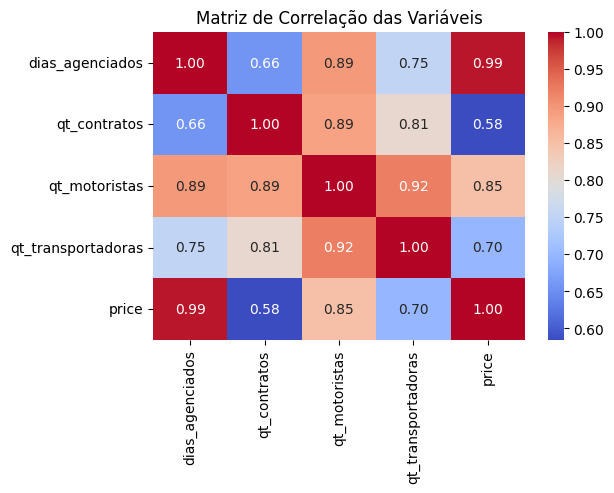

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras', 'price']

# Calcular a matriz de correlação
corr_matrix = contagem_mensal_uf[num_cols].corr()

# Plotar o heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de Correlação das Variáveis")
plt.show()



A escolha de dias agenciados e número de transportadoras como critérios para a distribuição das mesorregiões em carteiras é fundamentada em uma análise de correlação e impacto operacional. Dias agenciados representa diretamente a intensidade de trabalho ou o volume de operação em cada mesorregião, refletindo o esforço necessário para atender a demanda. Esse critério é um bom indicador de carga de trabalho, crucial para balancear as carteiras de forma eficiente, garantindo que as mesorregiões com maior volume de operação recebam a atenção adequada.

Além disso, ao incluir número de transportadoras, conseguimos incorporar uma variável que reflete a complexidade e diversidade operacional de cada mesorregião. Com uma correlação de 0,92 entre o número de contratos e o número de transportadoras, essa variável está intimamente relacionada ao volume de trabalho, mas também oferece uma visão mais ampla sobre a quantidade de parceiros logísticos envolvidos, o que é crucial para entender a diversidade de operações e os custos associados.

A combinação desses dois critérios permite uma distribuição equilibrada e estratégica, considerando tanto o volume operacional quanto a diversidade logística de cada mesorregião, o que resulta em carteiras mais ajustadas às necessidades reais de cada área. Assim, garantimos uma alocação eficiente e sustentável de recursos, alinhada aos objetivos operacionais da organização.

## distribuição das métricas por estado

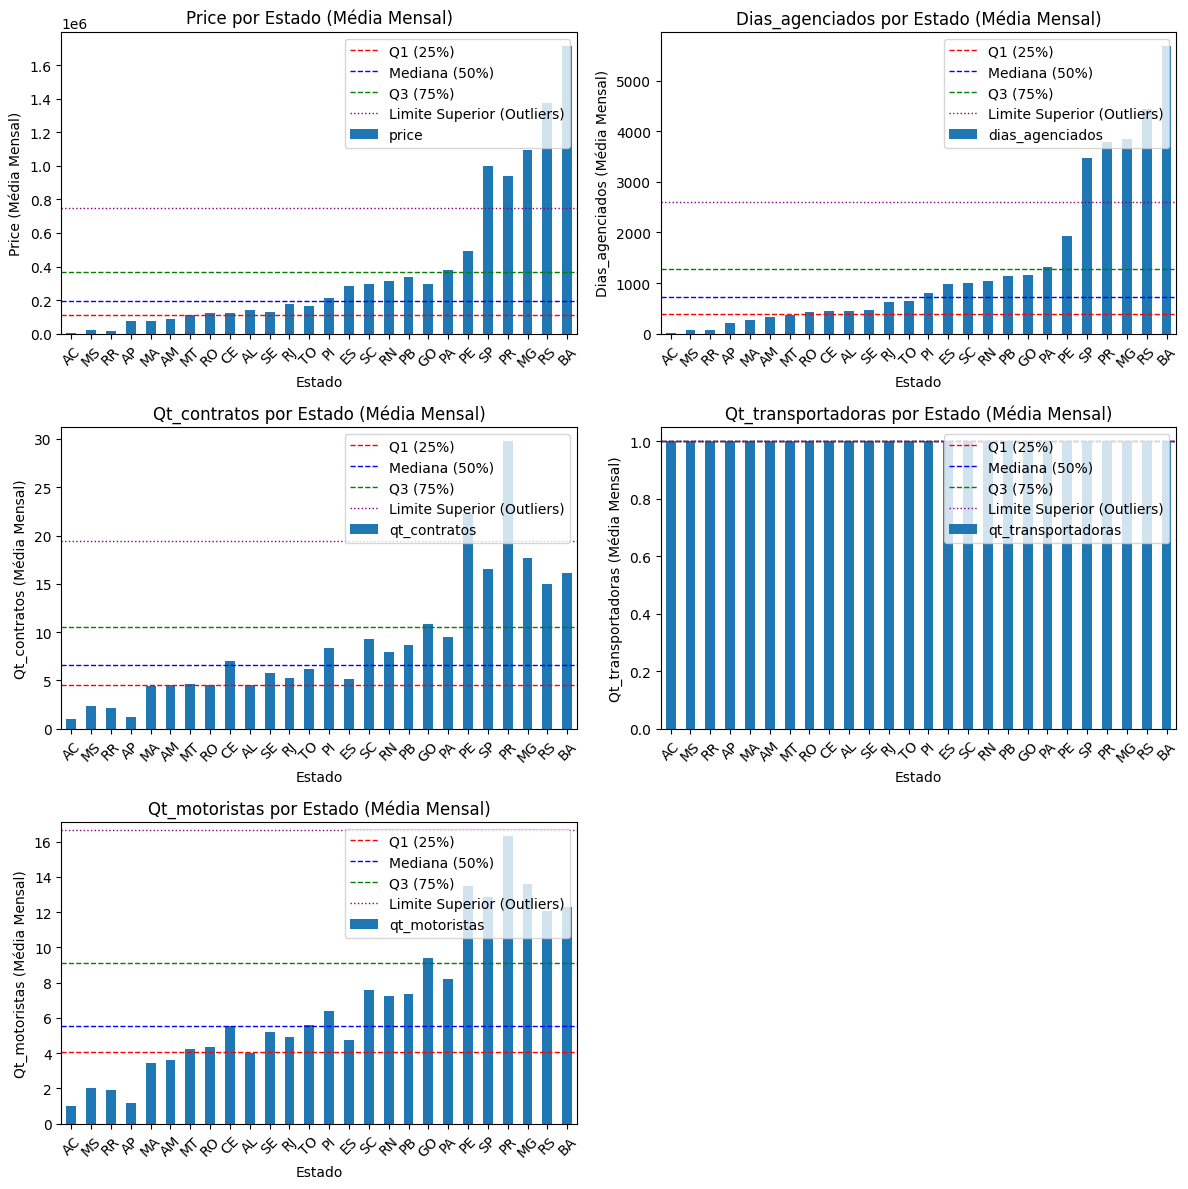

In [ ]:
# distribuição dos estados originais

metricas = ['price', 'dias_agenciados', 'qt_contratos', 'qt_transportadoras', 'qt_motoristas']


fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = mensal_estado[metrica].quantile(0.25)
    q2 = mensal_estado[metrica].median()
    q3 = mensal_estado[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    mensal_estado.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# DISTRIBUIÇÃO GEOGRÁFICA

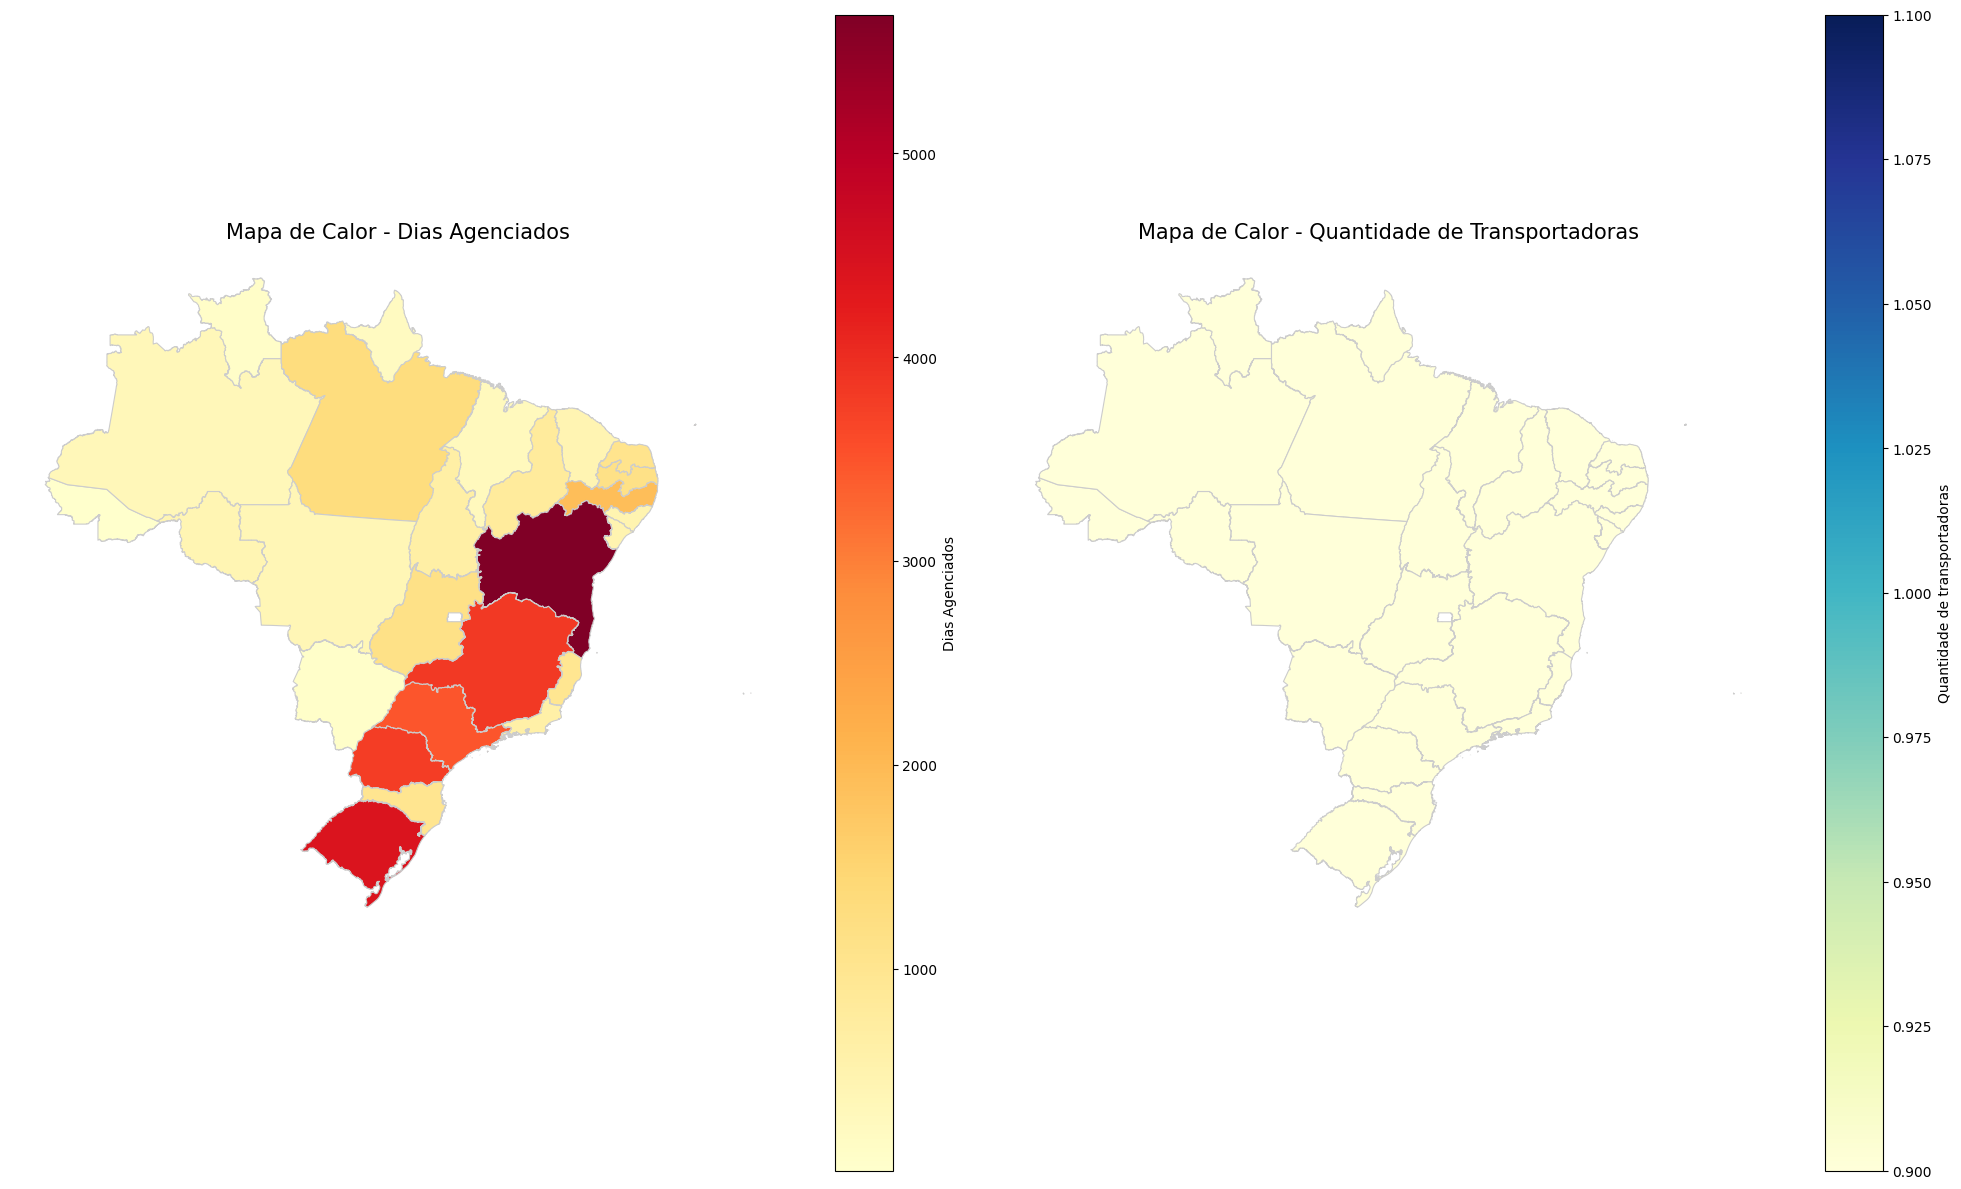

In [ ]:
from geobr import read_state

# Carregar a geometria dos estados do Brasil
states_gdf = read_state(year=2020)

# Unir os dados dos estados com as geometrias
states_gdf = states_gdf.merge(mensal_estado, left_on="abbrev_state", right_on="estado")

# Criar subplots para dois mapas de calor
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'dias_agenciados'
states_gdf.plot(
    column="dias_agenciados",
    cmap="YlOrRd",
    linewidth=0.8,
    ax=axes[0],
    edgecolor="0.8",
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
axes[0].set_title("Mapa de Calor - Dias Agenciados", fontsize=15)
axes[0].axis("off")

# Mapa de calor para 'dias_agenciados'
states_gdf.plot(
    column="qt_transportadoras",
    cmap="YlGnBu",
    linewidth=0.8,
    ax=axes[1],
    edgecolor="0.8",
    legend=True,
    legend_kwds={'label': "Quantidade de transportadoras"}
)
axes[1].set_title("Mapa de Calor - Quantidade de Transportadoras", fontsize=15)
axes[1].axis("off")

# Ajustar layout e exibir os gráficos
plt.tight_layout()
plt.show()

CRS de states_gdf: EPSG:4674
O CRS de gdf_mesorregioes está ausente. Atribuindo o EPSG:4674.


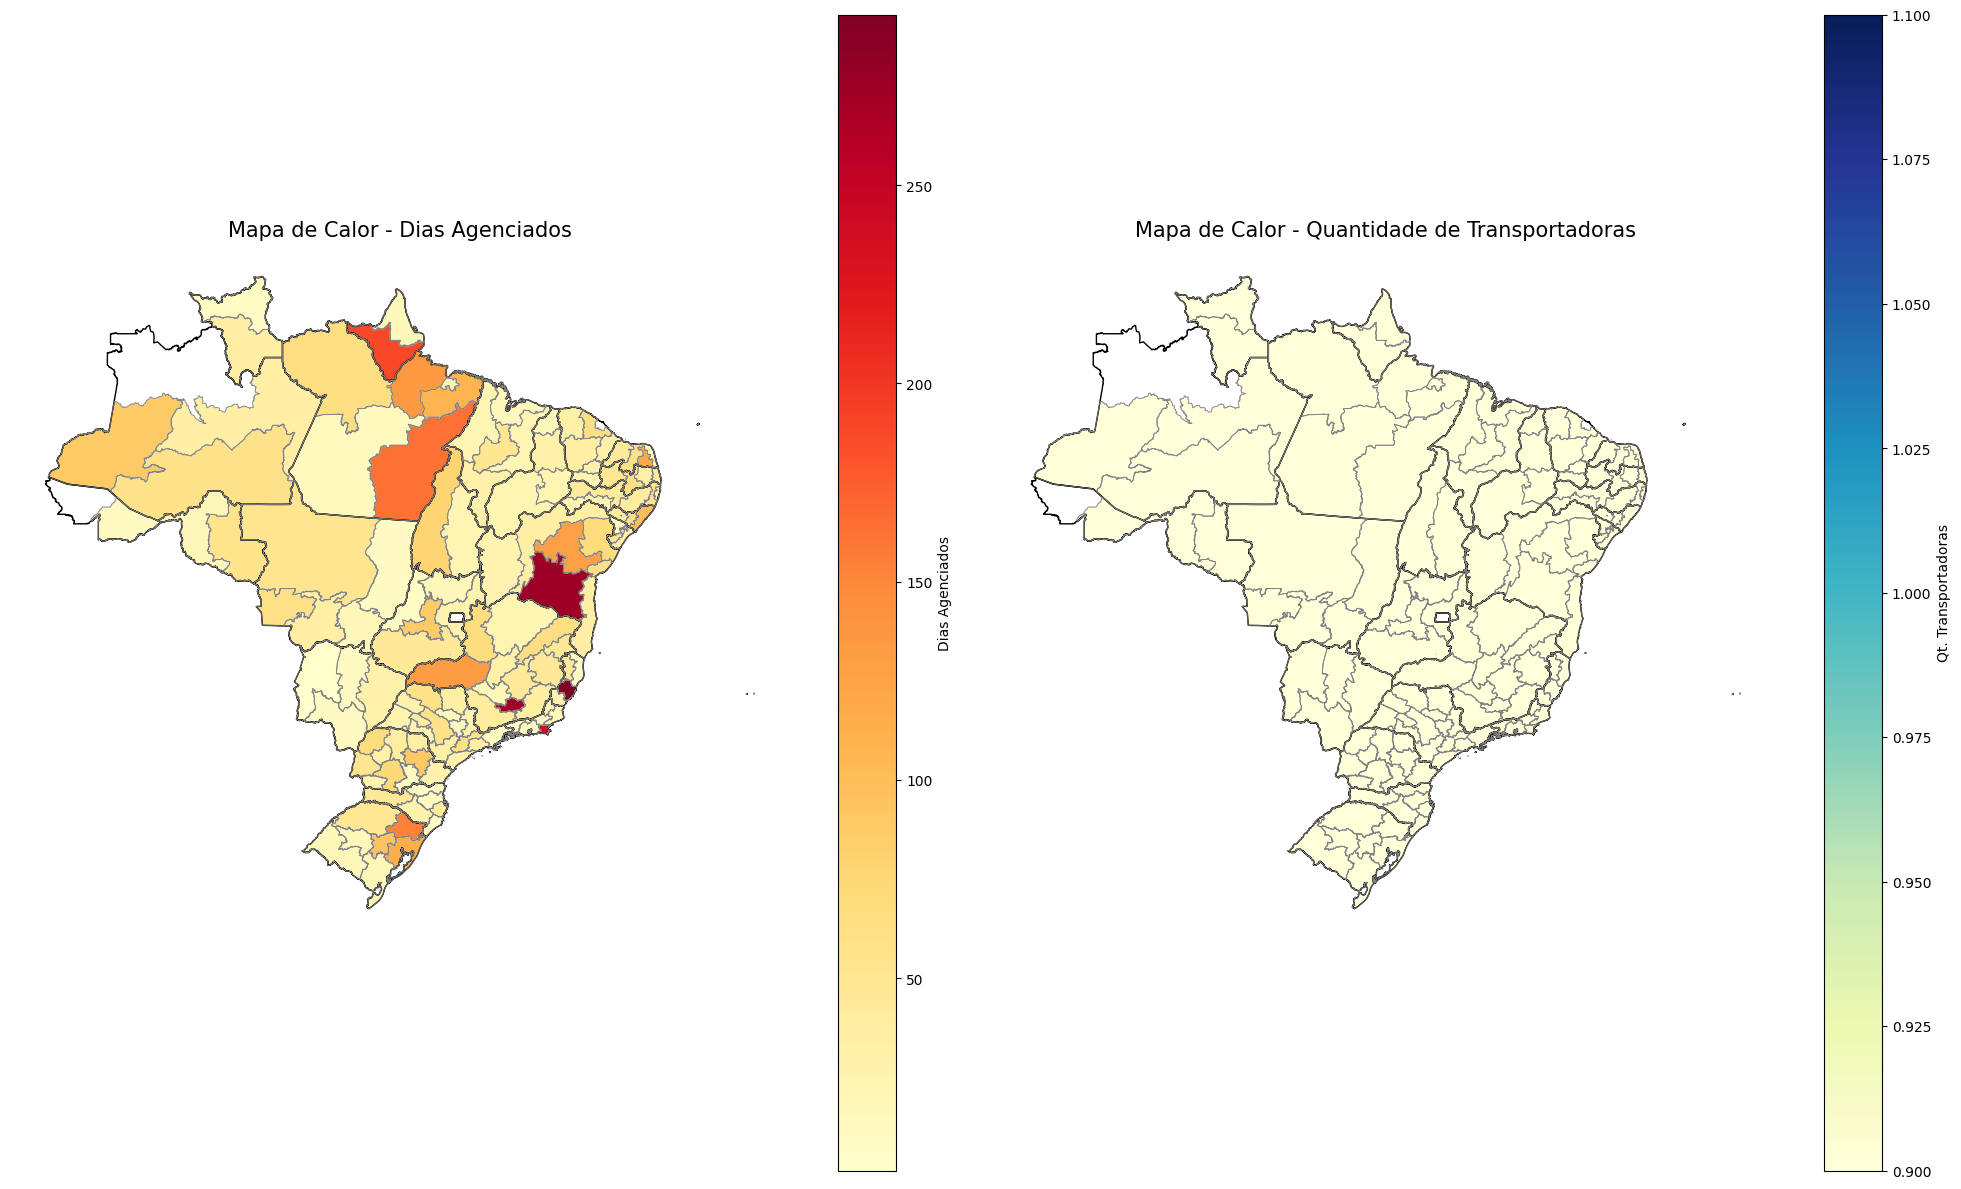

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from geobr import read_state

# Verifique se a coluna 'geometry_meso' contém strings válidas
mensal_meso['geometry_meso'] = mensal_meso['geometry_meso'].astype(str)

# Verificar se algum valor é NaN ou não válido
mensal_meso['geometry_meso'] = mensal_meso['geometry_meso'].apply(lambda x: None if x == 'None' else x)

# Agora, aplicar a conversão de WKT para geometria
mensal_meso['geometry'] = mensal_meso['geometry_meso'].apply(lambda x: wkt.loads(x) if x is not None else None)

# Converter o DataFrame para um GeoDataFrame
gdf_mesorregioes = gpd.GeoDataFrame(mensal_meso, geometry='geometry')

# Carregar os shapefiles dos estados brasileiros usando geobr
states_gdf = read_state(year=2020)

# Verificar CRS de 'states_gdf'
if states_gdf.crs is None:
    print("O CRS de states_gdf está ausente. Atribuindo o EPSG:4674.")
    states_gdf.set_crs("EPSG:4674", allow_override=True, inplace=True)
else:
    print(f"CRS de states_gdf: {states_gdf.crs}")

# Verificar CRS de 'gdf_mesorregioes'
if gdf_mesorregioes.crs is None:
    print("O CRS de gdf_mesorregioes está ausente. Atribuindo o EPSG:4674.")
    gdf_mesorregioes.set_crs("EPSG:4674", allow_override=True, inplace=True)
else:
    print(f"CRS de gdf_mesorregioes: {gdf_mesorregioes.crs}")

# Certificar-se de que ambos os GeoDataFrames estão no mesmo CRS (Sistema de Referência de Coordenadas)
if gdf_mesorregioes.crs != states_gdf.crs:
    print(f"Transformando gdf_mesorregioes de {gdf_mesorregioes.crs} para {states_gdf.crs}")
    gdf_mesorregioes = gdf_mesorregioes.to_crs(states_gdf.crs)

# Criar subplots para dois mapas
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'dias_agenciados' (primeiro mapa)
gdf_mesorregioes.plot(
    column='dias_agenciados',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': 'Dias Agenciados'}
)
axes[0].set_title('Mapa de Calor - Dias Agenciados', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'qt_transportadoras' (segundo mapa)
gdf_mesorregioes.plot(
    column='qt_transportadoras',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': 'Qt. Transportadoras'}
)
axes[1].set_title('Mapa de Calor - Quantidade de Transportadoras', fontsize=15)
axes[1].axis('off')

# Plotar as fronteiras dos estados para ambos os mapas
states_gdf.boundary.plot(ax=axes[0], color='black', linewidth=1)
states_gdf.boundary.plot(ax=axes[1], color='black', linewidth=1)

# Plotar as fronteiras das mesorregiões para ambos os mapas para maior clareza
gdf_mesorregioes.boundary.plot(ax=axes[0], color='gray', linewidth=0.5)
gdf_mesorregioes.boundary.plot(ax=axes[1], color='gray', linewidth=0.5)

# Ajustar o layout e exibir os gráficos
plt.tight_layout()
plt.show()


In [ ]:
regiões que não ultrapassam o limite não ha necissade de dividir em meso 

meso que não ultrapassam o limite, não há necessidade de dividr em micro

# CAIXEIRO VIAJANTE

In [ ]:
import pandas as pd
from geopy.distance import geodesic
import networkx as nx
from shapely.geometry import Polygon, MultiPolygon

# Função para calcular a distância entre duas coordenadas (centroide)
def calc_distance(coord1, coord2):
    return geodesic(coord1, coord2).km

# Função para obter o centroide de um polígono
def get_centroid(polygon):
    return polygon.centroid.x, polygon.centroid.y

# Criar o DataFrame de exemplo (ajustar com seus dados)
pcv = mensal_meso[['estado', 'meso', 'geometry', 'dias_agenciados']]
df = pcv.copy()

# Criar um gráfico onde cada mesorregião é um nó
G = nx.complete_graph(len(df))

# Definir as distâncias entre as mesorregiões como peso das arestas
for i in range(len(df)):
    for j in range(i+1, len(df)):
        # Obter o centroide das mesorregiões
        coord1 = get_centroid(df['geometry'][i])
        coord2 = get_centroid(df['geometry'][j])
        
        # Calcular a distância
        dist = calc_distance(coord1, coord2)
        
        # Adicionar a distância como peso das arestas
        G[i][j]['weight'] = dist
        G[j][i]['weight'] = dist

# Encontrar a mesorregião de 'Sudeste Rio-grandense'
start_node_index = df[df['meso'] == 'Sudeste Rio-grandense'].iloc[0].name

# Resolver o TSP sem o parâmetro 'start' (iniciaremos manualmente)
# Obtendo a ordem de visita e começando pela mesorregião do RS
tsp_path = nx.approximation.traveling_salesman_problem(G, cycle=False, weight='weight')

# Reorganizando a ordem para começar pela mesorregião de RS
start_index = tsp_path.index(start_node_index)
tsp_path = tsp_path[start_index:] + tsp_path[:start_index]

# Exibir a ordem das mesorregiões no caminho TSP
tsp_order = df.iloc[tsp_path].reset_index(drop=True)

# Adicionar uma coluna de numeração indicando a sequência do caminho TSP
tsp_order['num_sequence'] = tsp_order.index + 1

# Exibir o caminho TSP
print("Caminho TSP com numeração:")
display(tsp_order[['num_sequence', 'estado', 'meso', 'geometry']].head(3))

# Ajustar o TSP com a alocação de analistas
dias_target = 2185  # Definir o limite de dias por analista
analista_counter = 1  # Iniciar com o primeiro analista
total_dias = tsp_order.loc[0, 'dias_agenciados']  # Total de dias do analista atual
used_regions = [False] * len(tsp_order)  # Lista para marcar as regiões já atribuídas a um analista

# Atribuir analistas às mesorregiões (agora priorizando a soma total de dias)
analista_list = [analista_counter]
dias_acumulados = [total_dias]  # Lista para armazenar o total acumulado de dias por analista
used_regions[0] = True  # A primeira região já foi usada

for i in range(1, len(tsp_order)):
    total_dias += tsp_order.loc[i, 'dias_agenciados']
    
    # Se a soma acumulada de dias ultrapassar o limite (mais de 10%)
    if total_dias > dias_target * 1.1:
        # Realocar para a próxima região mais próxima sem ultrapassar o limite
        found = False
        for j in range(i + 1, len(tsp_order)):
            if used_regions[j]:
                continue  # Pular se a região já foi usada

            # Tentar adicionar a próxima região
            new_total_dias = total_dias + tsp_order.loc[j, 'dias_agenciados']
            if new_total_dias <= dias_target * 1.1 and new_total_dias >= dias_target * 0.9:
                # Se a soma fica entre 90% e 110%, alocar a região
                total_dias = new_total_dias
                analista_list.append(analista_counter)
                dias_acumulados.append(total_dias)
                used_regions[j] = True
                found = True
                break

        if not found:
            # Se não encontrou, mudar para o próximo analista
            analista_counter += 1
            total_dias = tsp_order.loc[i, 'dias_agenciados']  # Reinicia a contagem de dias com a nova mesorregião
            analista_list.append(analista_counter)
            dias_acumulados.append(total_dias)
            used_regions[i] = True  # Marcar a região como usada
    else:
        # Se a soma acumulada não ultrapassar o limite, continua com o analista atual
        analista_list.append(analista_counter)
        dias_acumulados.append(total_dias)

tsp_order['analista'] = analista_list

# Agrupar por analista e somar os dias agenciados
total_por_analista = tsp_order.groupby('analista', as_index=False).agg({
    'dias_agenciados': 'sum'
})

# Exibir os totais por analista
print("Totais por analista:")
display(total_por_analista)


Caminho TSP com numeração:


,num_sequence,estado,meso,geometry
0,1,RS,Sudeste Rio-grandense,"(POLYGON ((-52.622885 -32.145571, -52.624273 -..."
1,2,RS,Metropolitana de Porto Alegre,"(POLYGON ((-51.2719 -30.038972, -51.271924 -30..."
2,3,RS,Nordeste Rio-grandense,"POLYGON ((-51.616802 -29.377885, -51.616049 -2..."


Totais por analista:


,analista,dias_agenciados
0,1,2328.74
1,2,2107.14
2,3,2043.85
3,4,2317.04
4,5,2185.57
5,6,2340.11
6,7,2334.43
7,8,2075.94
8,9,3812.92
9,10,2356.69


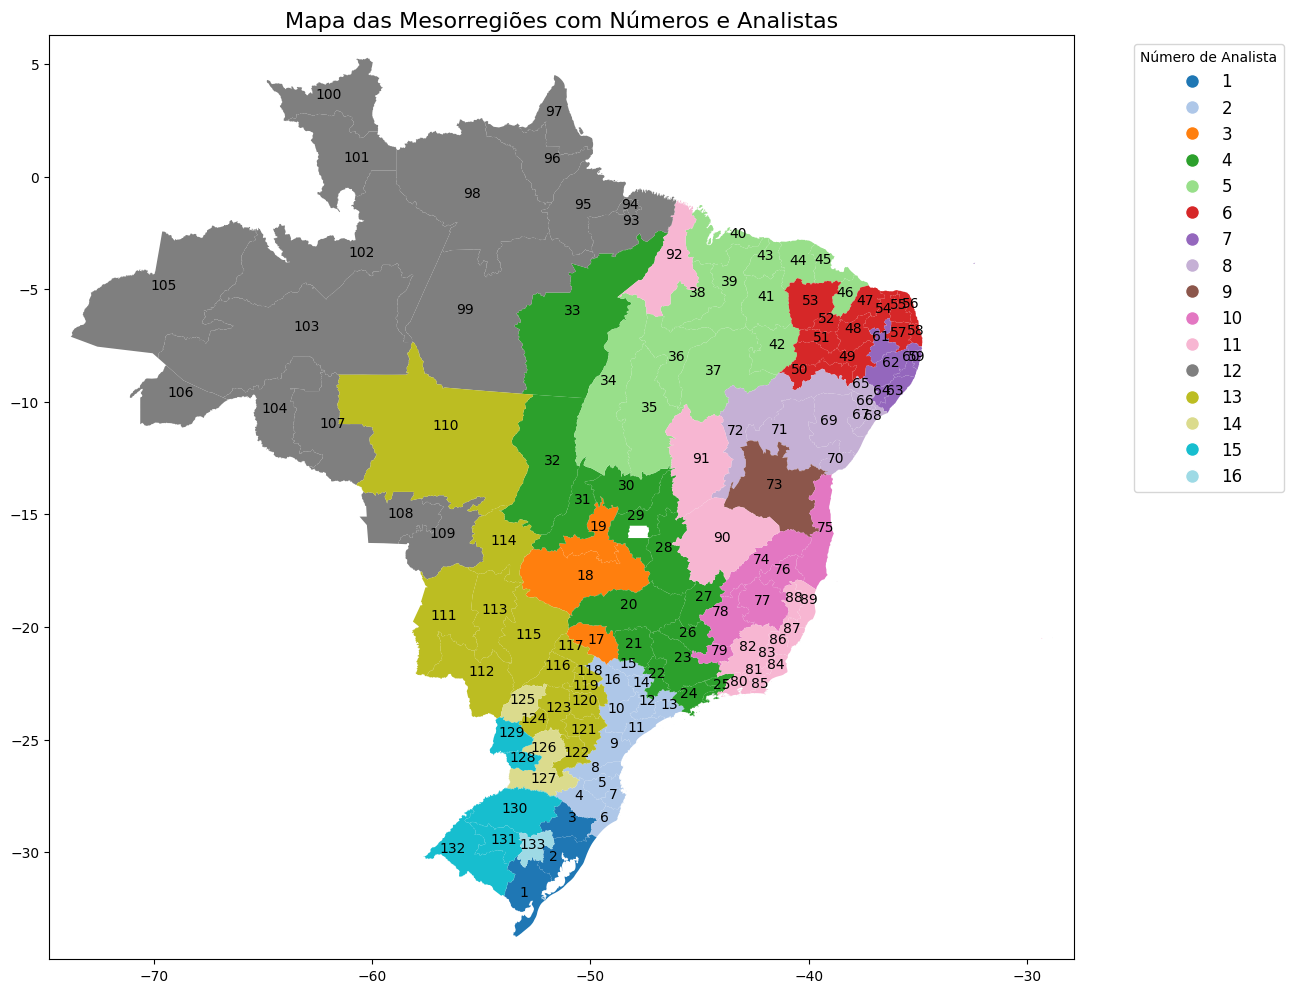

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Garantir que tsp_order seja um GeoDataFrame com geometria válida
if not isinstance(tsp_order, gpd.GeoDataFrame):
    tsp_order = gpd.GeoDataFrame(tsp_order, geometry='geometry')

# Garantir o CRS correto
tsp_order = tsp_order.set_crs("EPSG:4326", allow_override=True)

# Criar um mapa do Brasil
fig, ax = plt.subplots(figsize=(20, 12))

# Criar uma paleta de cores com base no número de analistas únicos
unique_analistas = tsp_order['analista'].unique()
colors = plt.cm.get_cmap('tab20', len(unique_analistas))  # Usando uma paleta de 20 cores

# Plotar as mesorregiões coloridas de acordo com o analista
tsp_order.plot(ax=ax, column='analista', cmap=colors, legend=False)

# Adicionar a legenda manualmente
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors(i), markersize=10) 
           for i in range(len(unique_analistas))]
labels = [str(analista) for analista in unique_analistas]

ax.legend(handles, labels, title="Número de Analista", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adicionar os números dentro de cada mesorregião
for i, row in tsp_order.iterrows():
    # Pega o ponto representativo da geometria
    point = row['geometry'].representative_point()
    lat, lon = point.y, point.x  # Acessa as coordenadas do ponto representativo
    ax.text(lon, lat, str(row['num_sequence']), fontsize=10, ha='center', color='black')  # Número dentro do polígono

# Ajustar os limites do mapa de acordo com os dados
x_min, y_min, x_max, y_max = tsp_order.total_bounds
ax.set_xlim([x_min - 1, x_max + 1])
ax.set_ylim([y_min - 1, y_max + 1])

# Título
plt.title('Mapa das Mesorregiões com Números e Analistas', fontsize=16)

# Exibir o mapa
plt.show()





## distribuição mapa

In [ ]:
def dividindo_top_estados(df, state_col, meso_col, target_cols):

    grouped_data = []

    # Iterar sobre os estados únicos
    for state in df[state_col].unique():
        state_data = df[df[state_col] == state]
        
        group_1 = []
        group_2 = []
        group_1_totals = {col: 0 for col in target_cols}
        group_2_totals = {col: 0 for col in target_cols}

        state_data_sorted = state_data.sort_values(by=target_cols[0], ascending=False)

        # Dividir mesorregiões entre os dois grupos
        for _, row in state_data_sorted.iterrows():
            if sum(group_1_totals.values()) <= sum(group_2_totals.values()):
                group_1.append(row)
                for col in target_cols:
                    group_1_totals[col] += row[col]
            else:
                group_2.append(row)
                for col in target_cols:
                    group_2_totals[col] += row[col]

        # Adicionar resultados ao grupo final
        for row in group_1:
            grouped_data.append({**row.to_dict(), 'group_id': 1})
        for row in group_2:
            grouped_data.append({**row.to_dict(), 'group_id': 2})

    # Construir DataFrame final
    grouped_df = pd.DataFrame(grouped_data)
    return grouped_df


# Carregar os dados de mesorregiões dos estados principais
top_estados = mensal_meso[mensal_meso['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR'])]

# Aplicar a função para dividir os estados
meso_total = dividindo_top_estados(
    top_estados, 
    state_col='estado', 
    meso_col='meso', 
    target_cols=['qt_contratos', 'price']
)

# Resumo por grupo e estado
meso_resumo = meso_total.groupby(['estado', 'group_id'])[['qt_contratos', 'price']].sum().reset_index()
meso_resumo['estado'] = meso_resumo['estado'].astype(str) + meso_resumo['group_id'].astype(str)
meso_resumo = meso_resumo.drop(columns=['group_id'])

# Exibir os resultados
print("Resumo dos totais por grupo e estado:")
print('meso_resumo')
display(meso_resumo)

print("Resumo detalhado por mesorregião:")
meso_total['estado'] = meso_total['estado'].astype(str) + meso_total['group_id'].astype(str)
meso_total = meso_total.drop(columns=['group_id'])
print("meso_total")
display(meso_total)

Resumo dos totais por grupo e estado:
meso_resumo


,estado,qt_contratos,price
0,BA1,171.62,1175820.15
1,BA2,185.38,536333.00
2,MG1,199.19,545717.44
3,MG2,217.12,554136.77
4,PR1,769.53,479349.85
5,PR2,432.30,461370.30
6,RS1,195.40,665834.46
7,RS2,111.64,714900.18
8,SP1,182.86,501231.92
9,SP2,250.77,520476.69


Resumo detalhado por mesorregião:
meso_total


,estado,meso,dias_agenciados,qt_contratos,qt_motoristas,qt_transportadoras,price,geometry
0,RS1,Noroeste Rio-grandense,1409.82,117.55,84.82,25.73,438221.00,"POLYGON ((-53.0167519139999 -29.155679731, -53..."
1,RS1,Centro Oriental Rio-grandense,600.64,43.27,34.09,6.18,186115.27,"POLYGON ((-52.0460455462042 -29.0577078495701,..."
2,RS1,Centro Ocidental Rio-grandense,67.00,24.91,9.73,3.91,15715.64,"POLYGON ((-54.040129825 -29.9174479549999, -54..."
3,RS1,Sudeste Rio-grandense,52.56,4.89,4.44,2.67,15265.22,(POLYGON ((-52.6228848621048 -32.1455712488285...
4,RS1,Sudoeste Rio-grandense,41.22,4.78,4.11,2.22,10517.33,"POLYGON ((-54.701293901 -31.4356677919999, -54..."
5,RS2,Metropolitana de Porto Alegre,1159.18,60.64,52.36,9.55,384453.09,"(POLYGON ((-51.271899645 -30.03897208, -51.271..."
6,RS2,Nordeste Rio-grandense,1117.00,51.00,42.45,6.18,330447.09,"POLYGON ((-51.6168022771846 -29.3778849840343,..."
7,MG1,Zona da Mata,439.85,80.85,40.77,11.00,115294.08,"POLYGON ((-42.1744937519999 -21.131777546, -42..."
8,MG1,Campo das Vertentes,1029.23,57.08,42.85,3.77,315801.00,"POLYGON ((-44.163559 -21.589391996, -44.163673..."
9,MG1,Noroeste de Minas,97.73,19.64,10.73,1.45,26403.82,"POLYGON ((-46.76082 -18.308766997, -46.761313 ..."


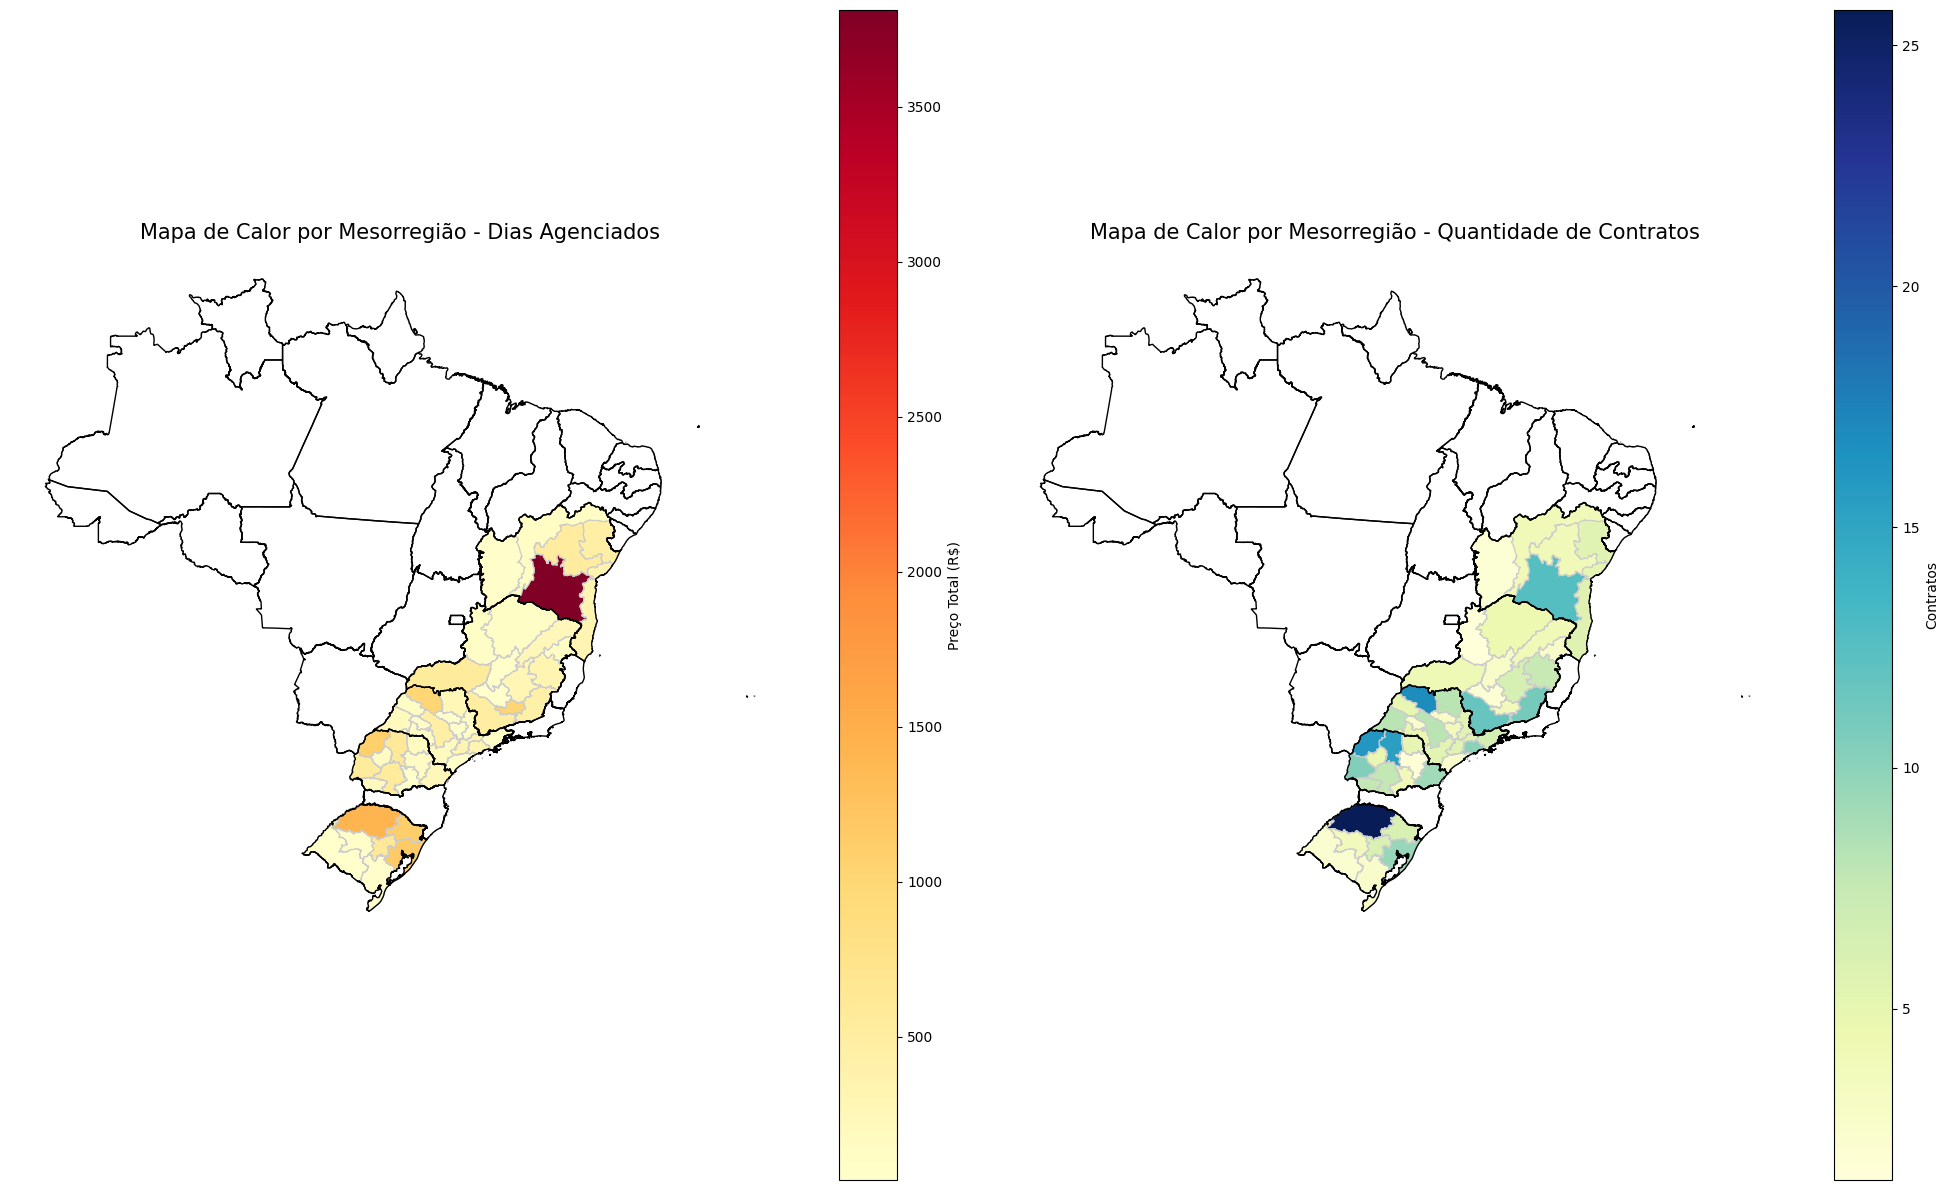

In [ ]:
# Dados fornecidos
data = meso_total.copy()

# Criar DataFrame e converter geometria de WKT para Shapely
df = pd.DataFrame(data)

# Garantir que a coluna 'geometry' seja string antes de aplicar wkt.loads
df['geometry'] = df['geometry'].astype(str).apply(wkt.loads)

# Converter para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Carregar o shapefile dos estados (ajuste conforme necessário)
states_gdf = read_state(year=2020)

# Criar subplots para mapas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
gdf.plot(
    column='dias_agenciados',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
# Plot dos estados sobre o mapa de preço
states_gdf.plot(
    ax=axes[0],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[0].set_title('Mapa de Calor por Mesorregião - Dias Agenciados', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'dias_agenciados'
gdf.plot(
    column='qt_transportadoras',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Contratos"}
)
# Plot dos estados sobre o mapa de dias agenciados
states_gdf.plot(
    ax=axes[1],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[1].set_title('Mapa de Calor por Mesorregião - Quantidade de Contratos', fontsize=15)
axes[1].axis('off')

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt

# Dados fornecidos
data = meso_total.copy()

# Criar DataFrame
df = pd.DataFrame(data)

# Garantir que a coluna 'geometry' seja string e converter para Shapely
df['geometry'] = df['geometry'].astype(str).apply(wkt.loads)

# Converter para GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Agrupar por estado, somar colunas numéricas e unir as geometrias
gdf_grouped = gdf.dissolve(
    by='estado',
    aggfunc={
        'dias_agenciados': 'sum',
        'contratos': 'sum',
        'motoristas': 'sum',
        'transportadoras': 'sum',
        'price': 'sum'
    }
)

# Carregar o shapefile dos estados (ajuste conforme necessário)
states_gdf = read_state(year=2020)

# Criar subplots para mapas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(20, 12))  # 1 linha, 2 colunas

# Mapa de calor para 'price'
gdf_grouped.plot(
    column='price',
    cmap='YlOrRd',
    linewidth=0.8,
    ax=axes[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Preço Total (R$)"}
)
# Plot dos estados sobre o mapa de preço
states_gdf.plot(
    ax=axes[0],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[0].set_title('Mapa de Calor por Estado - Preço Total dos Contratos', fontsize=15)
axes[0].axis('off')

# Mapa de calor para 'dias_agenciados'
gdf_grouped.plot(
    column='dias_agenciados',
    cmap='YlGnBu',
    linewidth=0.8,
    ax=axes[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Dias Agenciados"}
)
# Plot dos estados sobre o mapa de dias agenciados
states_gdf.plot(
    ax=axes[1],
    color='none',  # Transpárente
    edgecolor='black',
    linewidth=1
)
axes[1].set_title('Mapa de Calor por Estado - Dias Agenciados', fontsize=15)
axes[1].axis('off')

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()


KeyError: "Column(s) ['contratos', 'motoristas', 'transportadoras'] do not exist"

## ic_top_estados

In [ ]:
# Função para calcular o intervalo de confiança
def calcular_ic(coluna, nivel_confianca=0.95):
    media = coluna.mean()
    erro_padrao = stats.sem(coluna)
    intervalo = stats.t.interval(nivel_confianca, len(coluna) - 1, loc=media, scale=erro_padrao)
    return media, intervalo[0], intervalo[1]

# Colunas para as quais calcular IC
colunas = ['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']

# Calcular IC para cada coluna
resultados = []
for coluna in colunas:
    media, limite_inferior, limite_superior = calcular_ic(meso_resumo[coluna])
    resultados.append({
        'Coluna': coluna,
        'IC Inferior': limite_inferior,
        'Média': media,    
        'IC Superior': limite_superior
    })

# Criar DataFrame com os resultados
ic_top_estados = pd.DataFrame(resultados)

# Exibir a tabela
ic_top_estados


## estados_dividos

In [ ]:
estado_para_concat = mensal_estado[['estado', 'contratos', 'price', 'dias_agenciados','transportadoras', 'motoristas']]

# Filtrar 'estado' para eliminar os estados específicos
estado_filtrado = estado_para_concat[~estado_para_concat['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR', 'PE'])]

# Concatenar com group_totals
estados_divididos = pd.concat([estado_filtrado, meso_resumo], ignore_index=True)

# Exibir o DataFrame concatenado
estados_divididos


In [ ]:


fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = estados_divididos[metrica].quantile(0.25)
    q2 = estados_divididos[metrica].median()
    q3 = estados_divididos[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    estados_divididos.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# juntando estados menos ativos

In [ ]:
ic_top_estados

In [ ]:
menores = estados_divididos[['estado', 'contratos','price', 'dias_agenciados', 'transportadoras', 'motoristas']]

# Seleção das linhas para as regiões Norte, Nordeste, Centro-Oeste e Sudeste
linhas_selecionadas_norte = menores[menores['estado'].isin(['AC', 'AM', 'AP', 'RO', 'RR', 'PA'])]
linhas_selecionadas_nordeste = menores[menores['estado'].isin(['AL', 'CE', 'MA', 'PB', 'PI', 'RN','SE'])]
linhas_selecionadas_centro_oeste = menores[menores['estado'].isin(['GO', 'MS', 'MT','TO'])]
linhas_selecionadas_sudeste = menores[menores['estado'].isin(['ES', 'RJ'])]

# Somando as colunas selecionadas para a região Norte
soma_norte = linhas_selecionadas_norte[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_norte = linhas_selecionadas_norte['estado'].tolist()
estado_somado_norte = ', '.join(estados_norte)

# Somando as colunas selecionadas para a região Nordeste
soma_nordeste = linhas_selecionadas_nordeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_nordeste = linhas_selecionadas_nordeste['estado'].tolist()
estado_somado_nordeste = ', '.join(estados_nordeste)

# Somando as colunas selecionadas para a região Centro-Oeste
soma_centro_oeste = linhas_selecionadas_centro_oeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_centro_oeste = linhas_selecionadas_centro_oeste['estado'].tolist()
estado_somado_centro_oeste = ', '.join(estados_centro_oeste)

# Somando as colunas selecionadas para a região Sudeste (ES e RJ)
soma_sudeste = linhas_selecionadas_sudeste[['contratos', 'price', 'dias_agenciados', 'transportadoras', 'motoristas']].sum()
estados_sudeste = linhas_selecionadas_sudeste['estado'].tolist()
estado_somado_sudeste = ', '.join(estados_sudeste)

# Criando dicionários para as novas linhas
nova_linha_norte = {
    'estado': estado_somado_norte,
    'contratos': soma_norte['contratos'],
    'price': soma_norte['price'],
    'dias_agenciados': soma_norte['dias_agenciados'],
    'transportadoras': soma_norte['transportadoras'],
    'motoristas': soma_norte['motoristas']
}

nova_linha_nordeste = {
    'estado': estado_somado_nordeste,
    'contratos': soma_nordeste['contratos'],
    'price': soma_nordeste['price'],
    'dias_agenciados': soma_nordeste['dias_agenciados'],
    'transportadoras': soma_nordeste['transportadoras'],
    'motoristas': soma_nordeste['motoristas']
}

nova_linha_centro_oeste = {
    'estado': estado_somado_centro_oeste,
    'contratos': soma_centro_oeste['contratos'],
    'price': soma_centro_oeste['price'],
    'dias_agenciados': soma_centro_oeste['dias_agenciados'],
    'transportadoras': soma_centro_oeste['transportadoras'],
    'motoristas': soma_centro_oeste['motoristas']
}

nova_linha_sudeste = {
    'estado': estado_somado_sudeste,
    'contratos': soma_sudeste['contratos'],
    'price': soma_sudeste['price'],
    'dias_agenciados': soma_sudeste['dias_agenciados'],
    'transportadoras': soma_sudeste['transportadoras'],
    'motoristas': soma_sudeste['motoristas']
}

# Convertendo os dicionários em DataFrames
nova_linha_norte_df = pd.DataFrame([nova_linha_norte])
nova_linha_nordeste_df = pd.DataFrame([nova_linha_nordeste])
nova_linha_centro_oeste_df = pd.DataFrame([nova_linha_centro_oeste])
nova_linha_sudeste_df = pd.DataFrame([nova_linha_sudeste])

# Concatenando as novas linhas na tabela original
menores = pd.concat([menores, nova_linha_norte_df, nova_linha_nordeste_df, nova_linha_centro_oeste_df, nova_linha_sudeste_df], ignore_index=True)

# Excluindo as linhas selecionadas das regiões Norte, Nordeste, Centro-Oeste e Sudeste
menores = menores.drop(linhas_selecionadas_norte.index)
menores = menores.drop(linhas_selecionadas_nordeste.index)
menores = menores.drop(linhas_selecionadas_centro_oeste.index)
menores = menores.drop(linhas_selecionadas_sudeste.index)

# Exibindo as linhas das regiões Norte, Nordeste, Centro-Oeste e Sudeste que foram removidas
display(linhas_selecionadas_norte)
display(linhas_selecionadas_nordeste)
display(linhas_selecionadas_centro_oeste)
display(linhas_selecionadas_sudeste)

# Exibindo a tabela final
display(menores)

In [ ]:
# Verificar se os valores estão nos intervalos
resultados = []
for coluna in ic_top_estados['Coluna']:
    ic_inferior = ic_top_estados.loc[ic_top_estados['Coluna'] == coluna, 'IC Inferior'].values[0]
    ic_superior = ic_top_estados.loc[ic_top_estados['Coluna'] == coluna, 'IC Superior'].values[0]
    menores[f'{coluna}_no_IC'] = menores[coluna].apply(lambda x: ic_inferior <= x <= ic_superior)
    resultados.append(menores[[f'{coluna}_no_IC']].all().values[0])  # Checar se todos estão no IC

# Adicionar resultados gerais
menores['Dentro dos IC'] = menores[[f'{col}_no_IC' for col in ic_top_estados['Coluna']]].all(axis=1)

# Exibir os resultados
menores


In [ ]:

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Tamanho ajustado
axes = axes.flatten()  # Transformar em lista para iterar facilmente


for i, metrica in enumerate(metricas):
    # Calcular os quartis e o IQR para a métrica
    q1 = menores[metrica].quantile(0.25)
    q2 = menores[metrica].median()
    q3 = menores[metrica].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

  
    menores.plot(
        x='estado',
        y=metrica,
        kind='bar',
        ax=axes[i],  # Selecionar o eixo correspondente
        title=f'{metrica.capitalize()} por Estado (Média Mensal)'
    )

    # Adicionar linhas horizontais para Q1, Q2 (mediana), Q3 e limites de outliers
    axes[i].axhline(q1, color='red', linestyle='--', linewidth=1, label='Q1 (25%)')
    axes[i].axhline(q2, color='blue', linestyle='--', linewidth=1, label='Mediana (50%)')
    axes[i].axhline(q3, color='green', linestyle='--', linewidth=1, label='Q3 (75%)')

    axes[i].axhline(upper_bound, color='purple', linestyle=':', linewidth=1, label='Limite Superior (Outliers)')

    # Configurações adicionais
    axes[i].set_ylabel(f'{metrica.capitalize()} (Média Mensal)')
    axes[i].set_xlabel('Estado')
    axes[i].tick_params(axis='x', rotation=45)  # Rotação nos rótulos
    #axes[i].legend(loc='upper right')  # Adicionar legenda


for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])  

plt.tight_layout()
plt.show()


# METRICA UNICA

In [ ]:
metrica_unica = mensal_meso[['estado','meso' , 'dias_agenciados','price']]
metrica_unica

In [ ]:

importance_price = 0.568605  # Importância do price
importance_dias_agenciados = 0.391088  # Importância do dias_agenciados

participacao['metric'] = (participacao['price'] * importance_price) + (participacao['dias_agenciados'] * importance_dias_agenciados)

# Verificar o resultado
participacao[['estado', 'meso', 'dias_agenciados', 'price', 'metric']]

participacao

In [ ]:
participacao = mensal_meso[['estado','meso' , 'dias_agenciados','price']]

# 1. Calcular o total de dias_agenciados e price por estado
total_dias_agenciados_meso = participacao.dias_agenciados.sum()
total_price_meso = participacao.price.sum()

# 2. Calcular a proporção por estado (normalizada para que a soma seja 1 por estado)
participacao['proporcao_dias_agenciados_meso'] = participacao['dias_agenciados'] / total_dias_agenciados_meso
participacao['proporcao_price_meso'] = participacao['price'] / total_price_meso

participacao

In [ ]:

# Número total de funcionários
num_funcionarios = 10

# 2. Calcular o número de funcionários para cada estado/mesorregião com base nas proporções
participacao['funcionarios_dias_agenciados'] = (participacao['proporcao_dias_agenciados_meso'] * num_funcionarios).round()
participacao['funcionarios_price'] = (participacao['proporcao_price_meso'] * num_funcionarios).round()

# Verificar os resultados
participacao[['estado', 'meso', 'proporcao_dias_agenciados_meso', 'proporcao_price_meso', 
              'funcionarios_dias_agenciados', 'funcionarios_price']]


#### 2. Ajuste da distribuição (se necessário):


# Ajuste caso a soma não seja 10
diferenca_dias_agenciados = num_funcionarios - participacao['funcionarios_dias_agenciados'].sum()
diferenca_price = num_funcionarios - participacao['funcionarios_price'].sum()

# Ajuste a diferença nos estados/mesorregiões com maior proporção (ou qualquer outro critério)
# Aqui estamos apenas adicionando a diferença ao maior valor
if diferenca_dias_agenciados > 0:
    participacao.loc[participacao['funcionarios_dias_agenciados'].idxmax(), 'funcionarios_dias_agenciados'] += diferenca_dias_agenciados
if diferenca_price > 0:
    participacao.loc[participacao['funcionarios_price'].idxmax(), 'funcionarios_price'] += diferenca_price

# Verifique novamente
participacao[['estado', 'meso', 'funcionarios_dias_agenciados', 'funcionarios_price']]


In [ ]:
participacao = mensal_estado[['estado', 'dias_agenciados','price']]

# 1. Calcular o total de dias_agenciados e price por estado
total_dias_agenciados_estado = participacao.dias_agenciados.sum()
total_price_estado = participacao.price.sum()

# 2. Calcular a proporção por estado (normalizada para que a soma seja 1 por estado)
participacao['proporcao_dias_agenciados_estado'] = participacao['dias_agenciados'] / total_dias_agenciados_estado
participacao['proporcao_price_estado'] = participacao['price'] / total_price_estado

participacao

In [ ]:
participacao.sample(20)

## mensal_meso

# TRATAMENTO VARIAVEIS

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Copiar os dados dos últimos 3 meses
data = contagem_mensal_uf.copy()

# Selecionar as variáveis relevantes
features = ['sum_dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras', 'sum_price']

# Calcular a matriz de correlação
correlation_matrix = data[features].corr()

# Exibir a matriz de correlação
print('MATRIZ DE CORRELAÇÃO')
display(correlation_matrix)

# Visualizar a matriz de correlação usando um heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matriz de Correlação')
plt.show()



In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Carregar os dados
dados = mensal_meso_updated[['qt_contratos', 'price']]

# Normalizar as métricas (0 a 1)
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(dados)

# Adicionar a normalização ao DataFrame
mensal_meso_updated['qt_contratos_norm'] = dados_normalizados[:, 0]
mensal_meso_updated['price_norm'] = dados_normalizados[:, 1]

# Calcular o índice ponderado com peso 50% para cada métrica
mensal_meso_updated['indice'] = 0.5 * mensal_meso_updated['qt_contratos_norm'] + 0.5 * mensal_meso_updated['price_norm']

# Aplicar clustering para criar grupos balanceados
num_funcionarios = 5  # Ajuste para o número de funcionários
kmeans = KMeans(n_clusters=num_funcionarios, random_state=42)
mensal_meso_updated['grupo'] = kmeans.fit_predict(mensal_meso_updated[['indice']])

# Verificar a distribuição
print(mensal_meso_updated.groupby('grupo')[['qt_contratos', 'price']].sum())


# DIVISÃO EM GRUPOS

- **Divisão em Grupos Principais e Estados Adicionais**:
  - A partir do `mensal_estado`, os grupos principais (`PR`, `SP`, `MG`, `RS`, `BA`) são separados diretamente para `principal_states`.
  - Os estados restantes são alocados ao `group_extra_states`.

- **Modelo de Otimização**:
  - Usa **Programação Linear Inteira Mista (MILP)** para alocar estados de `group_extra_states` nos grupos principais de forma a minimizar a diferença de `price` entre os grupos.

- **Vantagens da Otimização**:
  - **Automação**: Não é necessário criar manualmente os `DataFrames`.
  - **Flexibilidade**: Se os grupos principais mudarem, o código se ajusta automaticamente, usando `mensal_estado` como base.

## 5 GRUPOS POR ESTADO - PRICE

In [ ]:


mapa_estados = read_state(year=2020)

# Simula os dados do DataFrame states_groups_df novamente
states_data = {
    'estado': ['AC', 'RR', 'MS', 'AP', 'MA', 'AM', 'CE', 'MT', 'RO', 'AL', 'SE', 'ES', 'TO', 'PI', 'RJ', 'GO', 'RN', 'SC', 'PB', 'PA', 'PE', 'PR', 'SP', 'MG', 'RS', 'BA'],
    'grupo_estado': ['G4', 'G1', 'G1', 'G3', 'G2', 'G3', 'G5', 'G1', 'G2', 'G4', 'G2', 'G5', 'G4', 'G5', 'G2', 'G4', 'G3', 'G3', 'G2', 'G3', 'G5', 'G3', 'G5', 'G2', 'G4', 'G1']
}
states_groups_df = pd.DataFrame(states_data)

# Simula os dados do DataFrame group_summary_with_states para a tabela
group_summary_with_states = pd.DataFrame({
    'grupo': ['G1', 'G2', 'G3', 'G4', 'G5'],
    'price': [1932706.50, 1932609.50, 1932490.92, 1932232.50, 1932534.75],
    'estado': [['BA', 'RR', 'MS', 'MT'], ['MG', 'MA', 'RO', 'SE', 'RJ', 'PB'], ['PR', 'AP', 'AM', 'RN', 'SC', 'PA'], ['RS', 'AC', 'AL', 'TO', 'GO'], ['SP', 'CE', 'ES', 'PI', 'PE']],
    'dias_agenciados': [6071.75, 6639.0, 6785.5, 6206.0, 6757.0],
    'qt_contratos': [464.75, 729.25, 1291.08, 578.75, 1442.5]
})

# Faz o merge do mapa com os dados dos grupos, considerando a coluna 'abbrev_state'
mapa_estados = mapa_estados.merge(states_groups_df, left_on='abbrev_state', right_on='estado')

# Define as cores dos grupos
group_colors = {
    'G1': '#66c2a5',
    'G2': '#fc8d62',
    'G3': '#8da0cb',
    'G4': '#e78ac3',
    'G5': '#a6d854'
}

# Criação do gráfico e da tabela ao lado, agora ajustando o tamanho e adicionando cores correspondentes na tabela
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), gridspec_kw={'width_ratios': [2, 1]})

# Plota os estados por grupo com as cores definidas
for group, color in group_colors.items():
    subset = mapa_estados[mapa_estados['grupo_estado'] == group]
    subset.plot(ax=ax1, color=color, label=group)

# Configurações do mapa
ax1.set_title('Distribuição dos Estados por Grupo')
ax1.axis('off')
ax1.legend(title="Grupos", loc='lower left')

# Cria a tabela ao lado do mapa, agora com cores correspondentes aos grupos
ax2.axis('off')
table_data = group_summary_with_states[['grupo',  'estado','price', 'dias_agenciados', 'qt_contratos','qt_motoristas', 'qt_transportadoras' ]]
row_colors = [group_colors[row['grupo']] for _, row in group_summary_with_states.iterrows()]
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center', loc='center', rowColours=row_colors)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))

# Exibe o gráfico e a tabela
plt.tight_layout()
plt.show()


## 7 GRUPOS POR ESTADO - PRICE

In [ ]:

from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Mantém BA e RS como grupos separados
ba_state = mensal_estado[mensal_estado['estado'] == 'BA'].reset_index(drop=True)
rs_state = mensal_estado[mensal_estado['estado'] == 'RS'].reset_index(drop=True)

target_price_ba = ba_state['price'].iloc[0]
target_price_rs = rs_state['price'].iloc[0]
target_price_avg = (target_price_ba + target_price_rs) / 2  # Valor de referência médio entre BA e RS

# Define os demais estados
remaining_states = mensal_estado[~mensal_estado['estado'].isin(['BA', 'RS'])].reset_index(drop=True)

# Definir um número menor de grupos para agrupar melhor os estados
num_groups = 5  # Reduzimos para tentar uma alocação mais equilibrada

# Cria o modelo de otimização
model = LpProblem("Group_Allocation_Improved", LpMinimize)

# Variáveis de decisão: Se o estado `j` é alocado ao grupo `g`
allocation_vars = {
    (j, g): LpVariable(f"assign_{j}_{g}", cat='Binary')
    for j in remaining_states.index for g in range(num_groups)
}

# Variáveis de desvio para representar a diferença entre `price` de cada grupo e o valor alvo (média de BA e RS)
deviation_vars = {g: LpVariable(f"deviation_{g}", lowBound=0) for g in range(num_groups)}

# Calcula o `price` total de cada grupo
price_vars = {g: lpSum(allocation_vars[j, g] * remaining_states.loc[j, 'price'] for j in remaining_states.index) for g in range(num_groups)}

# Função objetivo: Minimizar a soma dos desvios de `price` para cada grupo
model += lpSum(deviation_vars[g] for g in range(num_groups))

# Restrição 1: Cada estado em `remaining_states` deve ser atribuído a exatamente um grupo
for j in remaining_states.index:
    model += lpSum(allocation_vars[j, g] for g in range(num_groups)) == 1

# Restrição 2: As variáveis de desvio representam a diferença em relação ao valor alvo (média de BA e RS)
for g in range(num_groups):
    model += price_vars[g] - target_price_avg <= deviation_vars[g]
    model += target_price_avg - price_vars[g] <= deviation_vars[g]

# Restrição 3: Se um grupo não tiver nenhum estado atribuído, seu preço deve ser zero
for g in range(num_groups):
    model += price_vars[g] >= 0

# Resolve o modelo
model.solve()

# Exibe o status da solução
print("Status:", LpStatus[model.status])

# Exibe os resultados da alocação, garantindo que cada estado esteja apenas em um grupo
final_allocation = {'grupo': [], 'estados': []}
for g in range(num_groups):
    estados = [remaining_states.loc[j, 'estado'] for j in remaining_states.index if value(allocation_vars[j, g]) == 1]
    if len(estados) > 0:
        final_allocation['grupo'].append(f"G{g + 3}")  # G1 é BA e G2 é RS
        final_allocation['estados'].append(estados)

# Cria DataFrame da alocação dos grupos
final_allocation_df = pd.DataFrame(final_allocation)

# Inclui BA e RS no resultado final
final_allocation_df = pd.concat([
    pd.DataFrame({'grupo': ['G1'], 'estados': [['BA']]}),
    pd.DataFrame({'grupo': ['G2'], 'estados': [['RS']]}),
    final_allocation_df
], ignore_index=True)

# Calcula as métricas agregadas para cada grupo
final_groups = []

for index, row in final_allocation_df.iterrows():
    group_states = row['estados']
    group_data = mensal_estado[mensal_estado['estado'].isin(group_states)]
    
    # Calcula as métricas agregadas
    dias_agenciados = group_data['dias_agenciados'].sum()
    qt_contratos = group_data['qt_contratos'].sum()
    qt_motoristas = group_data['qt_motoristas'].sum()
    qt_transportadoras = group_data['qt_transportadoras'].sum()
    price = group_data['price'].sum()
    
    final_groups.append({
        'grupo': row['grupo'],
        'estados': group_states,
        'dias_agenciados': dias_agenciados,
        'qt_contratos': qt_contratos,
        'qt_motoristas': qt_motoristas,
        'qt_transportadoras': qt_transportadoras,
        'price': price
    })

# Cria DataFrame com as métricas agregadas e os estados de cada grupo
final_groups_df = pd.DataFrame(final_groups)

# Exibe o DataFrame final com os grupos e suas métricas agregadas
final_groups_df


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from geobr import read_state
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpStatus, value

# Carrega o shapefile dos estados do Brasil usando geobr
mapa_estados = read_state(year=2020)

# Define os grupos iniciais e as suas respectivas métricas
group_summary_with_states = pd.DataFrame({
    'grupo': ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7'],
    'estado': [['BA'], ['RS'], ['MT', 'PB', 'PR'], ['RR', 'AL', 'SE', 'SP'], ['AM', 'RJ', 'MG'], ['AP', 'MA', 'CE', 'RO', 'TO', 'PI', 'RN', 'PE'], ['AC', 'MS', 'ES', 'GO', 'SC', 'PA']],
    'price': [1281010.5, 1428322.0, 1282093.25, 1326606.75, 1326969.0, 1296921.92, 1190593.75],
    'dias_agenciados': [5655.0, 4374.5, 4626.25, 4418.75, 4674.75, 4693.25, 4020.75],
    'qt_contratos': [406.25, 331.0, 995.0, 559.25, 542.5, 1145.58, 523.75],
    'qt_motoristas': [254.75, 223.5, 409.75, 335.25, 325.0, 418.17, 306.5],
    'qt_transportadoras': [27.5, 35.5, 88.0, 77.5, 58.75, 99.83, 57.25]
})

# Cria um dicionário de mapeamento de estados para os grupos
estado_grupo_mapping = {}
for index, row in group_summary_with_states.iterrows():
    for estado in row['estado']:
        estado_grupo_mapping[estado] = row['grupo']

# Adiciona a coluna 'grupo' ao GeoDataFrame do mapa de estados
mapa_estados['grupo'] = mapa_estados['abbrev_state'].map(estado_grupo_mapping)

# Define as cores dos grupos
group_colors = {
    'G1': '#ff9999',  # Cor rosa claro
    'G2': '#66b3ff',  # Cor azul claro
    'G3': '#99ff99',  # Cor verde claro
    'G4': '#ffcc99',  # Cor laranja claro
    'G5': '#c2c2f0',  # Cor lilás claro
    'G6': '#ffb3e6',  # Cor rosa mais claro
    'G7': '#c4e17f'   # Cor verde amarelado
}

# Criação do gráfico e da tabela ao lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={'width_ratios': [2.5, 1]})

# Plota os estados por grupo com as cores definidas
for group, color in group_colors.items():
    subset = mapa_estados[mapa_estados['grupo'] == group]
    if not subset.empty:
        subset.plot(ax=ax1, color=color, label=group)

# Configurações do mapa
ax1.set_title('Distribuição dos Estados por Grupo', fontsize=16)
ax1.axis('off')
ax1.legend(title="Grupos", fontsize=10, title_fontsize=12)

# Cria a tabela ao lado do mapa
ax2.axis('off')
col_colors = ['#f2f2f2'] * len(group_summary_with_states.columns)
row_colors = [group_colors[group] for group in group_summary_with_states['grupo']]
table_data = group_summary_with_states[['grupo', 'estado', 'price', 'dias_agenciados', 'qt_contratos', 'qt_motoristas', 'qt_transportadoras']]
table = ax2.table(cellText=table_data.values,
                  colLabels=table_data.columns,
                  cellLoc='center', loc='center', rowColours=row_colors, colColours=col_colors)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_data.columns))))

# Ajusta o layout
plt.tight_layout()
plt.show()


# DIVIDINDO PRINCIPAIS ESTADOS

In [ ]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd

# Função para otimizar a divisão dos grupos
def optimize_groups(df, state_col, meso_col, target_cols, num_groups=2):
    grouped_data = []

    for state in df[state_col].unique():
        state_data = df[df[state_col] == state].reset_index(drop=True)
        num_regions = len(state_data)
        
        # Ajustar para garantir mais de um grupo por estado
        num_groups = min(num_groups, num_regions)  # Garantir no máximo o número de grupos igual ao número de mesorregiões

        # Criar a função objetivo para minimizar a diferença entre grupos
        c = np.zeros(num_regions * num_groups)  # Minimizar diferença entre grupos
        c[:num_regions] = 1  # Penaliza os itens do primeiro grupo

        # Restrições para equilibrar os totais de cada coluna em cada grupo
        A_eq = np.zeros((len(target_cols), num_regions * num_groups))
        b_eq = []

        for idx, col in enumerate(target_cols):
            A_eq[idx, :num_regions] = state_data[col].values
            for g in range(1, num_groups):
                A_eq[idx, num_regions*g:num_regions*(g+1)] = -state_data[col].values
            b_eq.append(0)  # Totais devem ser iguais para cada variável

        bounds = [(0, 1)] * (num_regions * num_groups)  # Limites entre 0 e 1 (grupo 1 ou 2 ou mais)

        # Restrições para garantir que cada mesorregião seja atribuída a um único grupo
        A_ub = np.zeros((num_regions, num_regions * num_groups))
        for i in range(num_regions):
            for g in range(num_groups):
                A_ub[i, i + num_regions * g] = 1
        
        # Resolver o problema de otimização
        res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=[1]*num_regions, bounds=bounds, method='highs')
        
        # Verificar se a solução foi encontrada
        if res.success:
            group_assignments = np.round(res.x[:num_regions]).astype(int)  # Atribuição de grupo para cada mesorregião

            for i, row in state_data.iterrows():
                grouped_data.append({**row.to_dict(), 'group_id': group_assignments[i] + 1})
        else:
            print(f"Problema com otimização para o estado {state}: {res.message}")

    grouped_df = pd.DataFrame(grouped_data)
    return grouped_df

# Aplicar a função
top_estados = mensal_meso[mensal_meso['estado'].isin(['SP', 'MG', 'RS', 'BA', 'PR'])]
grouped_meso = optimize_groups(
    top_estados,
    state_col='estado',
    meso_col='meso',
    target_cols=['qt_contratos', 'price', 'dias_agenciados', 'qt_transportadoras', 'qt_motoristas'],
    num_groups=2  # Definindo o número de grupos como 2 (ou altere para 3)
)

# Resumo por grupo
group_totals = grouped_meso.groupby(['estado', 'group_id'])[['qt_contratos', 'price', 'dias_agenciados', 'qt_transportadoras', 'qt_motoristas']].sum().reset_index()
display(group_totals)



In [ ]:
grouped_meso